# Record Linkage con Python Record Linkage Library

## Obiettivo 4.E
Definire **regole di record linkage** usando la libreria `recordlinkage` e valutare le pipeline:
- **B1-RecordLinkage**: Blocking (Manufacturer+Model) + Record Linkage
- **B2-RecordLinkage**: Blocking (Manufacturer+Model+Year) + Record Linkage

### Metriche di Valutazione:
- **Precision**: % di match predetti che sono veri match
- **Recall**: % di veri match correttamente identificati
- **F1-Score**: Media armonica di Precision e Recall
- **Tempi di Training**: Tempo per costruire il modello (se applicabile)
- **Tempi di Inferenza**: Tempo per classificare le coppie candidate

### Pipeline:
1. Caricare coppie candidate da B1 e B2 (generate dal blocking)
2. Calcolare **features di similarità** per ogni coppia:
   - Jaro-Winkler per stringhe (manufacturer, model)
   - Exact match per anno
   - Similarità numerica per price e mileage
3. Applicare **regole di classificazione**:
   - Threshold-based (regole deterministiche)
   - Oppure ML-based (Logistic Regression, etc.)
4. Valutare contro ground-truth
5. Confrontare B1 vs B2

## 1. Import Librerie e Installazione recordlinkage

In [86]:
# Installazione recordlinkage (se non presente)
# !pip install recordlinkage

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import recordlinkage as rl
from recordlinkage.compare import *
from recordlinkage.index import Block
import time
import json
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("✅ Librerie importate con successo!")
print(f"   recordlinkage version: {rl.__version__}")

✅ Librerie importate con successo!
   recordlinkage version: 0.16


## 2. Caricamento Dataset e Coppie Candidate

In [87]:
print("CARICAMENTO DATASET")
print("="*100)

# Carica dataset NO-VIN
print("\n📁 Dataset NO-VIN:")
df_A = pd.read_csv('ground_truth/dataset_A_no_vin.csv')
df_B = pd.read_csv('ground_truth/dataset_B_no_vin.csv')

# IMPORTANTE: Imposta vehicle_id come indice per recordlinkage
df_A = df_A.set_index('vehicle_id')
df_B = df_B.set_index('vehicle_id')

print(f"  Dataset A (Craigslist): {len(df_A):,} righe × {len(df_A.columns)} colonne")
print(f"  Dataset B (Used Cars): {len(df_B):,} righe × {len(df_B.columns)} colonne")

# Carica SOLO TEST SET per valutazione (NO DATA LEAKAGE!)
print("\n📁 Ground-Truth:")
df_test = pd.read_csv('ground_truth/test.csv')
df_test_positive = df_test[df_test['label'] == 1].copy()

print(f"  Test Set: {len(df_test):,} coppie (per valutazione)")
print(f"  Test Positivi: {len(df_test_positive):,} veri match")

# Carica coppie candidate da blocking
print("\n📁 Coppie Candidate (da Blocking):")
df_candidates_B1 = pd.read_csv('blocking_results/candidates_B1.csv')
df_candidates_B2 = pd.read_csv('blocking_results/candidates_B2.csv')

print(f"  B1 (Manufacturer+Model): {len(df_candidates_B1):,} coppie")
print(f"  B2 (Manufacturer+Model+Year): {len(df_candidates_B2):,} coppie")



CARICAMENTO DATASET

📁 Dataset NO-VIN:
  Dataset A (Craigslist): 14,492 righe × 18 colonne
  Dataset B (Used Cars): 15,375 righe × 18 colonne

📁 Ground-Truth:
  Test Set: 2,313 coppie (per valutazione)
  Test Positivi: 581 veri match

📁 Coppie Candidate (da Blocking):
  B1 (Manufacturer+Model): 964,002 coppie
  B2 (Manufacturer+Model+Year): 77,087 coppie


In [88]:
# 🔍 DEBUG: Verifica che B1 e B2 siano davvero diversi
print("\n🔍 DEBUG: VERIFICA DIFFERENZE TRA B1 E B2")
print("="*100)

print(f"\nNumero coppie:")
print(f"  B1: {len(df_candidates_B1):,} coppie")
print(f"  B2: {len(df_candidates_B2):,} coppie")

print(f"\nPrime 5 coppie B1:")
print(df_candidates_B1.head())

print(f"\nPrime 5 coppie B2:")
print(df_candidates_B2.head())

# Verifica se sono identici
if len(df_candidates_B1) == len(df_candidates_B2):
    print("\n⚠️ ATTENZIONE: B1 e B2 hanno lo stesso numero di coppie!")
    
    # Controlla se sono esattamente gli stessi
    b1_pairs = set(zip(df_candidates_B1['id_A'], df_candidates_B1['id_B']))
    b2_pairs = set(zip(df_candidates_B2['id_A'], df_candidates_B2['id_B']))
    
    if b1_pairs == b2_pairs:
        print("❌ ERRORE: B1 e B2 contengono ESATTAMENTE le stesse coppie!")
        print("   Controlla il notebook blocking_strategies.ipynb")
    else:
        comuni = len(b1_pairs.intersection(b2_pairs))
        print(f"✅ B1 e B2 hanno lo stesso numero ma coppie diverse")
        print(f"   Coppie in comune: {comuni:,}")
else:
    print(f"\n✅ B1 e B2 sono diversi!")
    print(f"   Differenza: {abs(len(df_candidates_B1) - len(df_candidates_B2)):,} coppie")


🔍 DEBUG: VERIFICA DIFFERENZE TRA B1 E B2

Numero coppie:
  B1: 964,002 coppie
  B2: 77,087 coppie

Prime 5 coppie B1:
         id_A       id_B    blocking_key
0  7303642099  275939497   mazda||mazda5
1  7303642099  276588038   mazda||mazda5
2  7303642099  280891179   mazda||mazda5
3  7316157713  279039916  ford||freestar
4  7316157713  280145772  ford||freestar

Prime 5 coppie B2:
         id_A       id_B            blocking_key
0  7316862831  277286875  nissan||frontier||2014
1  7316862831  278416174  nissan||frontier||2014
2  7316862831  277009965  nissan||frontier||2014
3  7315775182  277286875  nissan||frontier||2014
4  7315775182  278416174  nissan||frontier||2014

✅ B1 e B2 sono diversi!
   Differenza: 886,915 coppie


In [89]:
# Verifica schema e attributi disponibili
print("\nVERIFICA ATTRIBUTI DISPONIBILI")
print("="*100)

print("\nColonne Dataset A:")
print(list(df_A.columns))

print("\nColonne Dataset B:")
print(list(df_B.columns))

# Attributi comuni per similarità
common_attrs = set(df_A.columns).intersection(set(df_B.columns))
print(f"\nAttributi comuni: {len(common_attrs)}")
print(list(common_attrs))


VERIFICA ATTRIBUTI DISPONIBILI

Colonne Dataset A:
['body_type', 'cylinders', 'description', 'drive_type', 'exterior_color', 'fuel_type', 'image_url', 'latitude', 'listing_date', 'location', 'longitude', 'manufacturer', 'mileage', 'model', 'price', 'source_dataset', 'transmission', 'year']

Colonne Dataset B:
['body_type', 'cylinders', 'description', 'drive_type', 'exterior_color', 'fuel_type', 'image_url', 'latitude', 'listing_date', 'location', 'longitude', 'manufacturer', 'mileage', 'model', 'price', 'source_dataset', 'transmission', 'year']

Attributi comuni: 18
['transmission', 'year', 'cylinders', 'fuel_type', 'longitude', 'model', 'price', 'drive_type', 'body_type', 'image_url', 'latitude', 'mileage', 'manufacturer', 'exterior_color', 'listing_date', 'description', 'location', 'source_dataset']


## 3. Creazione MultiIndex per Coppie Candidate

La libreria `recordlinkage` richiede un **MultiIndex** con le coppie candidate.
Convertiamo le nostre coppie candidate (id_A, id_B) in questo formato.

In [90]:
def create_multiindex_pairs(df_candidates):
    """
    Converte DataFrame coppie candidate in MultiIndex per recordlinkage.
    
    Args:
        df_candidates: DataFrame con colonne 'id_A' e 'id_B'
        
    Returns:
        pd.MultiIndex con coppie (id_A, id_B)
    """
    pairs = pd.MultiIndex.from_arrays(
        [df_candidates['id_A'].values, df_candidates['id_B'].values],
        names=['id_A', 'id_B']
    )
    return pairs

print("CONVERSIONE COPPIE CANDIDATE IN MULTIINDEX")
print("="*100)

# Crea MultiIndex per B1
candidate_pairs_B1 = create_multiindex_pairs(df_candidates_B1)
print(f"\nB1 MultiIndex: {len(candidate_pairs_B1):,} coppie")
print(f"Esempio: {candidate_pairs_B1[:3].tolist()}")

# Crea MultiIndex per B2
candidate_pairs_B2 = create_multiindex_pairs(df_candidates_B2)
print(f"\nB2 MultiIndex: {len(candidate_pairs_B2):,} coppie")
print(f"Esempio: {candidate_pairs_B2[:3].tolist()}")

CONVERSIONE COPPIE CANDIDATE IN MULTIINDEX

B1 MultiIndex: 964,002 coppie
Esempio: [(7303642099, 275939497), (7303642099, 276588038), (7303642099, 280891179)]

B2 MultiIndex: 77,087 coppie
Esempio: [(7316862831, 277286875), (7316862831, 278416174), (7316862831, 277009965)]


In [91]:
# 🔍 DEBUG: Verifica MultiIndex
print("\n🔍 DEBUG: VERIFICA MULTIINDEX")
print("="*100)

print(f"\nLunghezza MultiIndex:")
print(f"  B1: {len(candidate_pairs_B1):,}")
print(f"  B2: {len(candidate_pairs_B2):,}")

if len(candidate_pairs_B1) == len(candidate_pairs_B2):
    print("\n❌ ERRORE: I MultiIndex hanno la stessa lunghezza!")
    print("   Questo NON dovrebbe accadere se i CSV sono diversi!")
else:
    print(f"\n✅ MultiIndex hanno lunghezze diverse!")
    
# Mostra esempi
print(f"\nPrime 3 coppie B1: {candidate_pairs_B1[:3].tolist()}")
print(f"Prime 3 coppie B2: {candidate_pairs_B2[:3].tolist()}")


🔍 DEBUG: VERIFICA MULTIINDEX

Lunghezza MultiIndex:
  B1: 964,002
  B2: 77,087

✅ MultiIndex hanno lunghezze diverse!

Prime 3 coppie B1: [(7303642099, 275939497), (7303642099, 276588038), (7303642099, 280891179)]
Prime 3 coppie B2: [(7316862831, 277286875), (7316862831, 278416174), (7316862831, 277009965)]


## 4. Calcolo Features di Similarità

Usiamo `recordlinkage.Compare` per calcolare similarità tra attributi delle coppie.

In [116]:
# ============================================================================
# CONFIGURAZIONE GLOBALE (facilmente modificabile)
# ============================================================================
CONFIG = {
    # Soglie per string matching (Jaro-Winkler)
    'manufacturer_threshold': 0.85,  # Threshold interno al comparatore
    'model_threshold': 0.85,
    'fuel_threshold': 0.85,
    'transmission_threshold': 0.85,
    
    # Parametri per year (Linear con tolleranza)
    'year_offset': 1.0,   # Tolleranza: ±1 anno = score 1.0
    'year_scale': 2.0,    # Differenza 2 anni = score ~0.5
    
    # Parametri per price (Gaussian)
    'price_offset': 500.0,    # Tolleranza $500
    'price_scale': 2000.0,    # Deviazione per Gaussian
    
    # Parametri per mileage (Gaussian)
    'mileage_offset': 5000.0,   # Tolleranza 5000 miglia
    'mileage_scale': 10000.0,   # Deviazione per Gaussian
    
    # Soglia per classificazione score-based
    'score_threshold': 5.2,   # Score minimo per match (su max ~6) - bilanciato
}

print("✅ Configurazione globale definita")
print(f"   Score threshold: {CONFIG['score_threshold']} (max teorico: ~7.0)")

def compute_similarity_features(df_A, df_B, candidate_pairs, strategy_name):
    """
    Calcola features di similarità per le coppie candidate.
    
    MIGLIORAMENTI rispetto alla versione base:
    - String matching con threshold interno (più efficiente)
    - Year con tolleranza ±1 anno (linear invece di exact)
    - Parametri configurabili globalmente
    
    Args:
        df_A: Dataset A con indice = vehicle_id
        df_B: Dataset B con indice = vehicle_id
        candidate_pairs: MultiIndex con coppie (id_A, id_B)
        strategy_name: Nome strategia (per log)
        
    Returns:
        DataFrame con features di similarità per ogni coppia
    """
    print(f"\nCALCOLO FEATURES DI SIMILARITÀ: {strategy_name}")
    print("-"*100)
    
    start_time = time.time()
    
    # Crea oggetto Compare
    compare = rl.Compare()
    
    # 1. Manufacturer - String similarity (Jaro-Winkler con threshold)
    if 'manufacturer' in df_A.columns and 'manufacturer' in df_B.columns:
        compare.string('manufacturer', 'manufacturer', method='jarowinkler', 
                      threshold=CONFIG['manufacturer_threshold'], label='manufacturer_sim')
        print(f"  ✓ manufacturer: Jaro-Winkler (threshold={CONFIG['manufacturer_threshold']})")
    
    # 2. Model - String similarity (Jaro-Winkler con threshold)
    if 'model' in df_A.columns and 'model' in df_B.columns:
        compare.string('model', 'model', method='jarowinkler', 
                      threshold=CONFIG['model_threshold'], label='model_sim')
        print(f"  ✓ model: Jaro-Winkler (threshold={CONFIG['model_threshold']})")
    
    # 3. Year - Linear con tolleranza (invece di exact match)
    # Linear: score = 1 se |diff| <= offset, poi decresce linearmente
    if 'year' in df_A.columns and 'year' in df_B.columns:
        compare.numeric('year', 'year', method='linear', 
                       offset=CONFIG['year_offset'], scale=CONFIG['year_scale'], 
                       label='year_sim')
        print(f"  ✓ year: Linear (offset={CONFIG['year_offset']}, scale={CONFIG['year_scale']})")
    
    # 4. Price - Numeric similarity (Gaussian)
    if 'price' in df_A.columns and 'price' in df_B.columns:
        compare.numeric('price', 'price', method='gauss', 
                       offset=CONFIG['price_offset'], scale=CONFIG['price_scale'], 
                       label='price_sim')
        print(f"  ✓ price: Gaussian (offset={CONFIG['price_offset']}, scale={CONFIG['price_scale']})")
    
    # 5. Mileage - Numeric similarity (Gaussian)
    if 'mileage' in df_A.columns and 'mileage' in df_B.columns:
        compare.numeric('mileage', 'mileage', method='gauss', 
                       offset=CONFIG['mileage_offset'], scale=CONFIG['mileage_scale'], 
                       label='mileage_sim')
        print(f"  ✓ mileage: Gaussian (offset={CONFIG['mileage_offset']}, scale={CONFIG['mileage_scale']})")
    
    # 6. Fuel - String similarity (con threshold)
    if 'fuel' in df_A.columns and 'fuel' in df_B.columns:
        compare.string('fuel', 'fuel', method='jarowinkler', 
                      threshold=CONFIG['fuel_threshold'], label='fuel_sim')
        print(f"  ✓ fuel: Jaro-Winkler (threshold={CONFIG['fuel_threshold']})")
    
    # 7. Transmission - String similarity (con threshold)
    if 'transmission' in df_A.columns and 'transmission' in df_B.columns:
        compare.string('transmission', 'transmission', method='jarowinkler', 
                      threshold=CONFIG['transmission_threshold'], label='transmission_sim')
        print(f"  ✓ transmission: Jaro-Winkler (threshold={CONFIG['transmission_threshold']})")
    
    # Calcola features
    print(f"\n  Calcolo features per {len(candidate_pairs):,} coppie...")
    features = compare.compute(candidate_pairs, df_A, df_B)
    
    elapsed_time = time.time() - start_time
    print(f"  ✅ Features calcolate in {elapsed_time:.2f} secondi")
    print(f"  Shape: {features.shape}")
    print(f"  Colonne: {list(features.columns)}")
    
    # Statistiche features
    print(f"\n  📊 Statistiche features:")
    for col in features.columns:
        print(f"     {col}: mean={features[col].mean():.3f}, >0: {(features[col] > 0).sum():,}")
    
    return features, elapsed_time

print("✅ Funzione di calcolo similarità definita (MIGLIORATA)")

✅ Configurazione globale definita
   Score threshold: 5.2 (max teorico: ~7.0)
✅ Funzione di calcolo similarità definita (MIGLIORATA)


In [104]:
# Calcola features per B1
features_B1, time_features_B1 = compute_similarity_features(
    df_A, df_B, candidate_pairs_B1, "B1 (Manufacturer+Model)"
)

print("\n" + "="*100)


CALCOLO FEATURES DI SIMILARITÀ: B1 (Manufacturer+Model)
----------------------------------------------------------------------------------------------------
  ✓ manufacturer: Jaro-Winkler (threshold=0.85)
  ✓ model: Jaro-Winkler (threshold=0.85)
  ✓ year: Linear (offset=1.0, scale=2.0)
  ✓ price: Gaussian (offset=500.0, scale=2000.0)
  ✓ mileage: Gaussian (offset=5000.0, scale=10000.0)
  ✓ transmission: Jaro-Winkler (threshold=0.85)

  Calcolo features per 964,002 coppie...
  ✅ Features calcolate in 2.05 secondi
  Shape: (964002, 6)
  Colonne: ['manufacturer_sim', 'model_sim', 'year_sim', 'price_sim', 'mileage_sim', 'transmission_sim']

  📊 Statistiche features:
     manufacturer_sim: mean=1.000, >0: 964,002
     model_sim: mean=1.000, >0: 964,002
     year_sim: mean=0.383, >0: 521,647
     price_sim: mean=0.119, >0: 960,138
     mileage_sim: mean=0.136, >0: 912,071
     transmission_sim: mean=0.461, >0: 444,348



In [105]:
# Calcola features per B2
features_B2, time_features_B2 = compute_similarity_features(
    df_A, df_B, candidate_pairs_B2, "B2 (Manufacturer+Model+Year)"
)

print("\n" + "="*100)


CALCOLO FEATURES DI SIMILARITÀ: B2 (Manufacturer+Model+Year)
----------------------------------------------------------------------------------------------------
  ✓ manufacturer: Jaro-Winkler (threshold=0.85)
  ✓ model: Jaro-Winkler (threshold=0.85)
  ✓ year: Linear (offset=1.0, scale=2.0)
  ✓ price: Gaussian (offset=500.0, scale=2000.0)
  ✓ mileage: Gaussian (offset=5000.0, scale=10000.0)
  ✓ transmission: Jaro-Winkler (threshold=0.85)

  Calcolo features per 77,087 coppie...
  ✅ Features calcolate in 0.18 secondi
  Shape: (77087, 6)
  Colonne: ['manufacturer_sim', 'model_sim', 'year_sim', 'price_sim', 'mileage_sim', 'transmission_sim']

  📊 Statistiche features:
     manufacturer_sim: mean=1.000, >0: 77,087
     model_sim: mean=1.000, >0: 77,087
     year_sim: mean=1.000, >0: 77,087
     price_sim: mean=0.312, >0: 76,909
     mileage_sim: mean=0.425, >0: 74,246
     transmission_sim: mean=0.462, >0: 35,645



In [94]:
# 🔍 DEBUG: Verifica Features
print("\n🔍 DEBUG: VERIFICA FEATURES")
print("="*100)

print(f"\nShape features:")
print(f"  B1: {features_B1.shape}")
print(f"  B2: {features_B2.shape}")

if features_B1.shape[0] == features_B2.shape[0]:
    print("\n❌ ERRORE: Le features hanno lo stesso numero di righe!")
    print("   features_B1 e features_B2 dovrebbero avere numero di righe diverso!")
else:
    print(f"\n✅ Features hanno numero di righe diverse!")
    print(f"   Differenza: {abs(features_B1.shape[0] - features_B2.shape[0]):,} righe")
    
print(f"\nPrime 3 righe features_B1:")
print(features_B1.head(3))

print(f"\nPrime 3 righe features_B2:")
print(features_B2.head(3))


🔍 DEBUG: VERIFICA FEATURES

Shape features:
  B1: (964002, 6)
  B2: (77087, 6)

✅ Features hanno numero di righe diverse!
   Differenza: 886,915 righe

Prime 3 righe features_B1:
                      manufacturer_sim  model_sim  year_match  price_sim  mileage_sim  transmission_match
id_A       id_B                                                                                          
7303642099 275939497               1.0        1.0           0   1.000000     0.001923                   1
           276588038               1.0        1.0           0   0.939562     0.096221                   0
           280891179               1.0        1.0           0   0.984525     0.981384                   0

Prime 3 righe features_B2:
                      manufacturer_sim  model_sim  year_match  price_sim  mileage_sim  transmission_match
id_A       id_B                                                                                          
7316862831 277286875               1.0        1.0 

In [95]:
# Visualizza esempi di features
print("\nESEMPI DI FEATURES CALCOLATE")
print("="*100)

print("\nB1 - Prime 10 coppie:")
print(features_B1.head(10))

print("\nStatistiche features B1:")
print(features_B1.describe())


ESEMPI DI FEATURES CALCOLATE

B1 - Prime 10 coppie:
                      manufacturer_sim  model_sim  year_match     price_sim   mileage_sim  transmission_match
id_A       id_B                                                                                              
7303642099 275939497               1.0        1.0           0  1.000000e+00  1.922882e-03                   1
           276588038               1.0        1.0           0  9.395618e-01  9.622070e-02                   0
           280891179               1.0        1.0           0  9.845252e-01  9.813845e-01                   0
7316157713 279039916               1.0        1.0           1  1.000000e+00  2.021804e-15                   1
           280145772               1.0        1.0           0  1.000000e+00  4.405192e-46                   1
           264055222               1.0        1.0           0  1.000000e+00  2.761283e-17                   0
7313763725 278739018               1.0        1.0           0  2.76

In [96]:
# 🔍 ANALISI DISTRIBUZIONE FEATURES
print("\n🔍 ANALISI DISTRIBUZIONE FEATURES")
print("="*100)

# Analizza quante coppie soddisfano ciascuna regola
print("\nB1 - Distribuzione soglie:")
print(f"  manufacturer_sim >= 0.90: {(features_B1.get('manufacturer_sim', 0) >= 0.90).sum():,} coppie")
print(f"  manufacturer_sim >= 0.95: {(features_B1.get('manufacturer_sim', 0) >= 0.95).sum():,} coppie")
print(f"  manufacturer_sim == 1.00: {(features_B1.get('manufacturer_sim', 0) == 1.00).sum():,} coppie")

print(f"\n  model_sim >= 0.85: {(features_B1.get('model_sim', 0) >= 0.85).sum():,} coppie")
print(f"  model_sim >= 0.90: {(features_B1.get('model_sim', 0) >= 0.90).sum():,} coppie")
print(f"  model_sim >= 0.95: {(features_B1.get('model_sim', 0) >= 0.95).sum():,} coppie")

print(f"\n  year_match == 1: {(features_B1.get('year_match', 0) == 1).sum():,} coppie")

print(f"\n  price_sim >= 0.80: {(features_B1.get('price_sim', 0) >= 0.80).sum():,} coppie")
print(f"  price_sim >= 0.90: {(features_B1.get('price_sim', 0) >= 0.90).sum():,} coppie")

print(f"\n  mileage_sim >= 0.70: {(features_B1.get('mileage_sim', 0) >= 0.70).sum():,} coppie")
print(f"  mileage_sim >= 0.80: {(features_B1.get('mileage_sim', 0) >= 0.80).sum():,} coppie")

# Combinate
all_rules = (
    (features_B1.get('manufacturer_sim', 0) >= 0.90) &
    (features_B1.get('model_sim', 0) >= 0.85) &
    (features_B1.get('year_match', 0) == 1) &
    (features_B1.get('price_sim', 0) >= 0.80) &
    (features_B1.get('mileage_sim', 0) >= 0.70)
)
print(f"\n  Tutte le regole attuali soddisfatte: {all_rules.sum():,} coppie")
print(f"  Percentuale: {all_rules.sum()/len(features_B1)*100:.2f}%")



🔍 ANALISI DISTRIBUZIONE FEATURES

B1 - Distribuzione soglie:
  manufacturer_sim >= 0.90: 964,002 coppie
  manufacturer_sim >= 0.95: 964,002 coppie
  manufacturer_sim == 1.00: 964,002 coppie

  model_sim >= 0.85: 964,002 coppie
  model_sim >= 0.90: 964,002 coppie
  model_sim >= 0.95: 964,002 coppie

  year_match == 1: 77,087 coppie

  price_sim >= 0.80: 416,768 coppie
  price_sim >= 0.90: 354,722 coppie

  mileage_sim >= 0.70: 199,631 coppie
  mileage_sim >= 0.80: 177,110 coppie

  Tutte le regole attuali soddisfatte: 30,698 coppie
  Percentuale: 3.18%


In [99]:
# 🔍 ANALISI FALSI POSITIVI
print("\n🔍 ANALISI FALSI POSITIVI - Perché la precision è così bassa?")
print("="*100)

# Conta coppie che soddisfano le regole ULTRA stringenti
ultra_strict = (
    (features_B1.get('manufacturer_sim', 0) == 1.0) &
    (features_B1.get('model_sim', 0) >= 0.95) &
    (features_B1.get('year_match', 0) == 1) &
    (features_B1.get('price_sim', 0) >= 0.90) &
    (features_B1.get('mileage_sim', 0) >= 0.85) &
    (features_B1.get('transmission_match', 0) == 1)  # TRANSMISSION OBBLIGATORIO
)

print(f"\nRegole ULTRA STRINGENTI (con fuel + transmission OBBLIGATORI):")
print(f"  Coppie che soddisfano TUTTE le regole: {ultra_strict.sum():,}")
print(f"  Percentuale: {ultra_strict.sum()/len(features_B1)*100:.4f}%")

# Statistiche attributi opzionali
print(f"\nAttributi opzionali:")
print(f"  transmission_match == 1: {(features_B1.get('transmission_match', 0) == 1).sum():,} coppie")
print(f"  fuel AND transmission match: {((features_B1.get('fuel_match', 0) == 1) & (features_B1.get('transmission_match', 0) == 1)).sum():,} coppie")



🔍 ANALISI FALSI POSITIVI - Perché la precision è così bassa?

Regole ULTRA STRINGENTI (con fuel + transmission OBBLIGATORI):
  Coppie che soddisfano TUTTE le regole: 11,264
  Percentuale: 1.1685%

Attributi opzionali:
  transmission_match == 1: 444,348 coppie
  fuel AND transmission match: 0 coppie


## 5. Regole di Classificazione

Definiamo **regole deterministiche** per classificare le coppie come match/non-match.

In [106]:
def apply_classification_rules(features, rule_name="default", method="score"):
    """
    Applica regole di classificazione alle features di similarità.
    
    Supporta DUE METODI:
    1. 'score': Somma tutti gli score e usa soglia (più flessibile)
    2. 'rules': Regole AND rigide su ogni attributo
    
    Il metodo score-based permette compensazione: un campo forte
    può compensare un campo debole.
    
    Args:
        features: DataFrame con features di similarità
        rule_name: Nome delle regole (per log)
        method: 'score' (default) o 'rules'
        
    Returns:
        pd.Series con predizioni (1=match, 0=non-match)
    """
    print(f"\nAPPLICAZIONE REGOLE DI CLASSIFICAZIONE: {rule_name}")
    print("-"*100)
    print(f"  Metodo: {method.upper()}")
    
    # Copia features per evitare modifiche
    df = features.copy()
    
    if method == "score":
        # ===================================================================
        # METODO 1: SCORE-BASED (più flessibile)
        # ===================================================================
        # Somma tutti gli score delle features
        scores = df.sum(axis=1)
        
        # Classifica in base alla soglia
        threshold = CONFIG['score_threshold']
        predictions = (scores >= threshold).astype(int)
        
        print(f"\n  📊 Score-based classification:")
        print(f"    Soglia: {threshold}")
        print(f"    Max score teorico: {len(df.columns)} (se tutti = 1.0)")
        print(f"    Score medio: {scores.mean():.3f}")
        print(f"    Score max: {scores.max():.3f}")
        print(f"    Score min: {scores.min():.3f}")
        
        # Distribuzione scores
        print(f"\n  📈 Distribuzione scores:")
        for t in [3.0, 4.0, 5.0, 5.5, 6.0, 6.5]:
            count = (scores >= t).sum()
            print(f"    Score >= {t}: {count:,} ({count/len(scores)*100:.2f}%)")
        
    else:
        # ===================================================================
        # METODO 2: RULES-BASED (AND logico)
        # ===================================================================
        # Regola 1: Manufacturer con alta similarità
        rule_manufacturer = (df.get('manufacturer_sim', pd.Series([0]*len(df))) >= 0.90)
        
        # Regola 2: Model con alta similarità  
        rule_model = (df.get('model_sim', pd.Series([0]*len(df))) >= 0.85)
        
        # Regola 3: Year simile (ora usa year_sim invece di year_match)
        if 'year_sim' in df.columns:
            rule_year = (df['year_sim'] >= 0.5)  # Anno entro ±2 anni
        elif 'year_match' in df.columns:
            rule_year = (df['year_match'] == 1)
        else:
            rule_year = pd.Series([True]*len(df), index=df.index)
        
        # Regola 4: Price simile
        rule_price = (df.get('price_sim', pd.Series([0]*len(df))) >= 0.50)
        
        # Regola 5: Mileage simile
        rule_mileage = (df.get('mileage_sim', pd.Series([0]*len(df))) >= 0.30)
        
        # Regola FINALE: TUTTE le condizioni (AND logico)
        predictions = (rule_manufacturer & rule_model & rule_year & 
                       rule_price & rule_mileage).astype(int)
        
        print(f"\n  Regole applicate (AND logico):")
        print(f"    1. manufacturer_sim >= 0.90")
        print(f"    2. model_sim >= 0.85")
        print(f"    3. year_sim >= 0.50 (o year_match == 1)")
        print(f"    4. price_sim >= 0.50")
        print(f"    5. mileage_sim >= 0.30")
        
        # Statistiche dettagliate
        print(f"\n  Statistiche regole:")
        print(f"    - Soddisfa manufacturer_sim >= 0.90: {rule_manufacturer.sum():,}")
        print(f"    - Soddisfa model_sim >= 0.85: {rule_model.sum():,}")
        print(f"    - Soddisfa year: {rule_year.sum():,}")
        print(f"    - Soddisfa price_sim >= 0.50: {rule_price.sum():,}")
        print(f"    - Soddisfa mileage_sim >= 0.30: {rule_mileage.sum():,}")
    
    print(f"\n  ✅ Risultato:")
    print(f"    Match predetti: {predictions.sum():,}")
    print(f"    Non-match: {len(predictions) - predictions.sum():,}")
    print(f"    Percentuale match: {predictions.sum()/len(predictions)*100:.4f}%")
    
    return predictions

print("✅ Funzione di classificazione definita (MIGLIORATA)")
print("   Supporta: method='score' (default) o method='rules'")

✅ Funzione di classificazione definita (MIGLIORATA)
   Supporta: method='score' (default) o method='rules'


In [117]:
# Applica regole a B1 - Usa metodo SCORE-BASED (default)
# Puoi cambiare method='rules' per usare le regole AND rigide
start_time_B1 = time.time()
predictions_B1 = apply_classification_rules(features_B1, "B1-RecordLinkage", method="score")
time_inference_B1 = time.time() - start_time_B1

print(f"\n  ⏱️  Tempo di inferenza B1: {time_inference_B1:.4f} secondi")
print("\n" + "="*100)


APPLICAZIONE REGOLE DI CLASSIFICAZIONE: B1-RecordLinkage
----------------------------------------------------------------------------------------------------
  Metodo: SCORE

  📊 Score-based classification:
    Soglia: 5.2
    Max score teorico: 6 (se tutti = 1.0)
    Score medio: 3.099
    Score max: 6.000
    Score min: 2.000

  📈 Distribuzione scores:
    Score >= 3.0: 606,238 (62.89%)
    Score >= 4.0: 173,342 (17.98%)
    Score >= 5.0: 32,315 (3.35%)
    Score >= 5.5: 9,787 (1.02%)
    Score >= 6.0: 1,036 (0.11%)
    Score >= 6.5: 0 (0.00%)

  ✅ Risultato:
    Match predetti: 16,058
    Non-match: 947,944
    Percentuale match: 1.6658%

  ⏱️  Tempo di inferenza B1: 0.0640 secondi



In [118]:
# Applica regole a B2 - Usa metodo SCORE-BASED (default)
# Puoi cambiare method='rules' per usare le regole AND rigide
start_time_B2 = time.time()
predictions_B2 = apply_classification_rules(features_B2, "B2-RecordLinkage", method="score")
time_inference_B2 = time.time() - start_time_B2

print(f"\n  ⏱️  Tempo di inferenza B2: {time_inference_B2:.4f} secondi")
print("\n" + "="*100)


APPLICAZIONE REGOLE DI CLASSIFICAZIONE: B2-RecordLinkage
----------------------------------------------------------------------------------------------------
  Metodo: SCORE

  📊 Score-based classification:
    Soglia: 5.2
    Max score teorico: 6 (se tutti = 1.0)
    Score medio: 4.199
    Score max: 6.000
    Score min: 3.000

  📈 Distribuzione scores:
    Score >= 3.0: 77,087 (100.00%)
    Score >= 4.0: 50,774 (65.87%)
    Score >= 5.0: 12,701 (16.48%)
    Score >= 5.5: 4,208 (5.46%)
    Score >= 6.0: 655 (0.85%)
    Score >= 6.5: 0 (0.00%)

  ✅ Risultato:
    Match predetti: 6,028
    Non-match: 71,059
    Percentuale match: 7.8197%

  ⏱️  Tempo di inferenza B2: 0.0062 secondi



In [59]:
# 🔍 DEBUG: Verifica Predizioni
print("\n🔍 DEBUG: VERIFICA PREDIZIONI")
print("="*100)

print(f"\nNumero predizioni:")
print(f"  B1: {len(predictions_B1)}")
print(f"  B2: {len(predictions_B2)}")

print(f"\nMatch predetti:")
print(f"  B1: {predictions_B1.sum()}")
print(f"  B2: {predictions_B2.sum()}")

if len(predictions_B1) == len(predictions_B2) and predictions_B1.sum() == predictions_B2.sum():
    print("\n❌ ERRORE: predictions_B1 e predictions_B2 sono identici!")
    print("   Questo spiega perché le metriche sono uguali!")
    
    # Verifica se sono esattamente gli stessi
    if (predictions_B1 == predictions_B2).all():
        print("   predictions_B1 e predictions_B2 sono ESATTAMENTE uguali elemento per elemento")
    else:
        print("   Hanno lo stesso numero di match ma predizioni diverse")
else:
    print(f"\n✅ Predizioni diverse!")
    print(f"   B1: {len(predictions_B1)} predizioni con {predictions_B1.sum()} match")
    print(f"   B2: {len(predictions_B2)} predizioni con {predictions_B2.sum()} match")


🔍 DEBUG: VERIFICA PREDIZIONI

Numero predizioni:
  B1: 964002
  B2: 77087

Match predetti:
  B1: 30698
  B2: 30698

✅ Predizioni diverse!
   B1: 964002 predizioni con 30698 match
   B2: 77087 predizioni con 30698 match


## 6. Valutazione con Ground-Truth

In [60]:
def evaluate_predictions(predictions, candidate_pairs, df_test_positive, strategy_name):
    """
    Valuta le predizioni contro TEST SET (no data leakage!).
    
    Args:
        predictions: Serie con predizioni (1=match, 0=non-match)
        candidate_pairs: MultiIndex con coppie candidate
        df_test_positive: Ground-truth con solo coppie positive DAL TEST SET
        strategy_name: Nome strategia
        
    Returns:
        dict: Metriche di valutazione
    """
    print(f"\nVALUTAZIONE: {strategy_name}")
    print("="*100)
    
    # Crea set di veri match DAL TEST SET ONLY
    true_matches = set(
        zip(df_test_positive['craigslist_id'], 
            df_test_positive['used_cars_id'])
    )
    
    # Crea ground-truth labels per le coppie candidate
    y_true = []
    y_pred = []
    
    for i, (id_a, id_b) in enumerate(candidate_pairs):
        # True label
        is_true_match = 1 if (id_a, id_b) in true_matches else 0
        y_true.append(is_true_match)
        
        # Predicted label
        y_pred.append(predictions.iloc[i])
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calcola metriche
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📊 METRICHE (TEST SET):")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall: {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score: {f1:.4f} ({f1*100:.2f}%)")
    
    print(f"\n📊 CONFUSION MATRIX:")
    print(f"  True Positives (TP): {tp:,} - Match correttamente identificati")
    print(f"  True Negatives (TN): {tn:,} - Non-match correttamente identificati")
    print(f"  False Positives (FP): {fp:,} - Non-match classificati come match (Errore Tipo I)")
    print(f"  False Negatives (FN): {fn:,} - Match classificati come non-match (Errore Tipo II)")
    
    print(f"\n  Totale coppie candidate: {len(y_true):,}")
    print(f"  Veri match nel test set: {y_true.sum():,}")
    print(f"  Match predetti: {y_pred.sum():,}")
    
    return {
        'strategy': strategy_name,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'tp': int(tp),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'total_candidates': len(y_true),
        'true_matches': int(y_true.sum()),
        'predicted_matches': int(y_pred.sum())
    }

print("✅ Funzione di valutazione definita")


✅ Funzione di valutazione definita


In [119]:
# Valuta B1 (usando TEST SET)
metrics_B1 = evaluate_predictions(
    predictions_B1,
    candidate_pairs_B1,
    df_test_positive,
    "B1-RecordLinkage"
)

print("\n" + "="*100)



VALUTAZIONE: B1-RecordLinkage

📊 METRICHE (TEST SET):
  Precision: 0.0079 (0.79%)
  Recall: 0.3780 (37.80%)
  F1-Score: 0.0155 (1.55%)

📊 CONFUSION MATRIX:
  True Positives (TP): 127 - Match correttamente identificati
  True Negatives (TN): 947,735 - Non-match correttamente identificati
  False Positives (FP): 15,931 - Non-match classificati come match (Errore Tipo I)
  False Negatives (FN): 209 - Match classificati come non-match (Errore Tipo II)

  Totale coppie candidate: 964,002
  Veri match nel test set: 336
  Match predetti: 16,058



In [120]:
# Valuta B2 (usando TEST SET)
metrics_B2 = evaluate_predictions(
    predictions_B2,
    candidate_pairs_B2,
    df_test_positive,
    "B2-RecordLinkage"
)

print("\n" + "="*100)



VALUTAZIONE: B2-RecordLinkage

📊 METRICHE (TEST SET):
  Precision: 0.0211 (2.11%)
  Recall: 0.3780 (37.80%)
  F1-Score: 0.0399 (3.99%)

📊 CONFUSION MATRIX:
  True Positives (TP): 127 - Match correttamente identificati
  True Negatives (TN): 70,850 - Non-match correttamente identificati
  False Positives (FP): 5,901 - Non-match classificati come match (Errore Tipo I)
  False Negatives (FN): 209 - Match classificati come non-match (Errore Tipo II)

  Totale coppie candidate: 77,087
  Veri match nel test set: 336
  Match predetti: 6,028



## 7. Confronto Pipeline e Tempi

In [121]:
# Tabella comparativa completa
print("\nTABELLA COMPARATIVA B1-RecordLinkage vs B2-RecordLinkage")
print("="*100)

comparison_data = {
    'Strategia': ['B1-RecordLinkage', 'B2-RecordLinkage'],
    'Coppie Candidate': [metrics_B1['total_candidates'], metrics_B2['total_candidates']],
    'Match Predetti': [metrics_B1['predicted_matches'], metrics_B2['predicted_matches']],
    'Precision': [f"{metrics_B1['precision']:.4f}", f"{metrics_B2['precision']:.4f}"],
    'Recall': [f"{metrics_B1['recall']:.4f}", f"{metrics_B2['recall']:.4f}"],
    'F1-Score': [f"{metrics_B1['f1_score']:.4f}", f"{metrics_B2['f1_score']:.4f}"],
    'TP': [metrics_B1['tp'], metrics_B2['tp']],
    'FP': [metrics_B1['fp'], metrics_B2['fp']],
    'FN': [metrics_B1['fn'], metrics_B2['fn']],
    'Tempo Features (s)': [f"{time_features_B1:.2f}", f"{time_features_B2:.2f}"],
    'Tempo Inferenza (s)': [f"{time_inference_B1:.4f}", f"{time_inference_B2:.4f}"]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Tempi totali
total_time_B1 = time_features_B1 + time_inference_B1
total_time_B2 = time_features_B2 + time_inference_B2

print("\n" + "="*100)
print("TEMPI TOTALI (Features + Inferenza):")
print(f"  B1: {total_time_B1:.2f} secondi")
print(f"  B2: {total_time_B2:.2f} secondi")
print(f"  ⚡ B2 è {total_time_B1/total_time_B2:.1f}x più veloce di B1!")

# Reduction Ratio
print("\n" + "="*100)
print("EFFICIENZA DEL BLOCKING (Reduction Ratio):")
cartesian_product = len(df_A) * len(df_B)
rr_B1 = 1 - (metrics_B1['total_candidates'] / cartesian_product)
rr_B2 = 1 - (metrics_B2['total_candidates'] / cartesian_product)
print(f"  Prodotto Cartesiano: {cartesian_product:,} coppie")
print(f"  B1 Reduction Ratio: {rr_B1*100:.4f}% (riduce {rr_B1*100:.2f}% dei confronti)")
print(f"  B2 Reduction Ratio: {rr_B2*100:.4f}% (riduce {rr_B2*100:.2f}% dei confronti)")
print(f"  ⚡ B2 riduce {metrics_B1['total_candidates']/metrics_B2['total_candidates']:.1f}x più coppie di B1!")

# Spiegazione metriche identiche
print("\n" + "="*100)
print("📊 ANALISI RISULTATI:")
print("-"*100)
if metrics_B1['precision'] == metrics_B2['precision'] and metrics_B1['recall'] == metrics_B2['recall']:
    print("⚠️ NOTA: Precision, Recall e F1 sono IDENTICI per B1 e B2!")
    print("")
    print("   SPIEGAZIONE:")
    print("   - B2 (manufacturer+model+year) è un SOTTOINSIEME di B1 (manufacturer+model)")
    print("   - Tutte le coppie match trovate in B2 sono ANCHE in B1")
    print("   - Quindi TP, FP, FN sono identici → metriche identiche")
    print("")
    print("   DIFFERENZA CHIAVE:")
    print(f"   - B1 processa {metrics_B1['total_candidates']:,} coppie")
    print(f"   - B2 processa {metrics_B2['total_candidates']:,} coppie")
    print(f"   - B2 è {metrics_B1['total_candidates']/metrics_B2['total_candidates']:.1f}x più efficiente!")
    print("")
    print("   ✅ RACCOMANDAZIONE: Usa B2-RecordLinkage")
    print("      Stessa qualità, MOLTO più veloce!")
else:
    if metrics_B1['f1_score'] > metrics_B2['f1_score']:
        print("✅ MIGLIORE STRATEGIA: B1-RecordLinkage")
        print(f"   F1-Score: {metrics_B1['f1_score']:.4f} > {metrics_B2['f1_score']:.4f}")
    else:
        print("✅ MIGLIORE STRATEGIA: B2-RecordLinkage")
        print(f"   F1-Score: {metrics_B2['f1_score']:.4f} > {metrics_B1['f1_score']:.4f}")


TABELLA COMPARATIVA B1-RecordLinkage vs B2-RecordLinkage
       Strategia  Coppie Candidate  Match Predetti Precision Recall F1-Score  TP    FP  FN Tempo Features (s) Tempo Inferenza (s)
B1-RecordLinkage            964002           16058    0.0079 0.3780   0.0155 127 15931 209               2.05              0.0640
B2-RecordLinkage             77087            6028    0.0211 0.3780   0.0399 127  5901 209               0.18              0.0062

TEMPI TOTALI (Features + Inferenza):
  B1: 2.11 secondi
  B2: 0.18 secondi
  ⚡ B2 è 11.7x più veloce di B1!

EFFICIENZA DEL BLOCKING (Reduction Ratio):
  Prodotto Cartesiano: 222,814,500 coppie
  B1 Reduction Ratio: 99.5674% (riduce 99.57% dei confronti)
  B2 Reduction Ratio: 99.9654% (riduce 99.97% dei confronti)
  ⚡ B2 riduce 12.5x più coppie di B1!

📊 ANALISI RISULTATI:
----------------------------------------------------------------------------------------------------
✅ MIGLIORE STRATEGIA: B2-RecordLinkage
   F1-Score: 0.0399 > 0.0155


## 8. Visualizzazioni

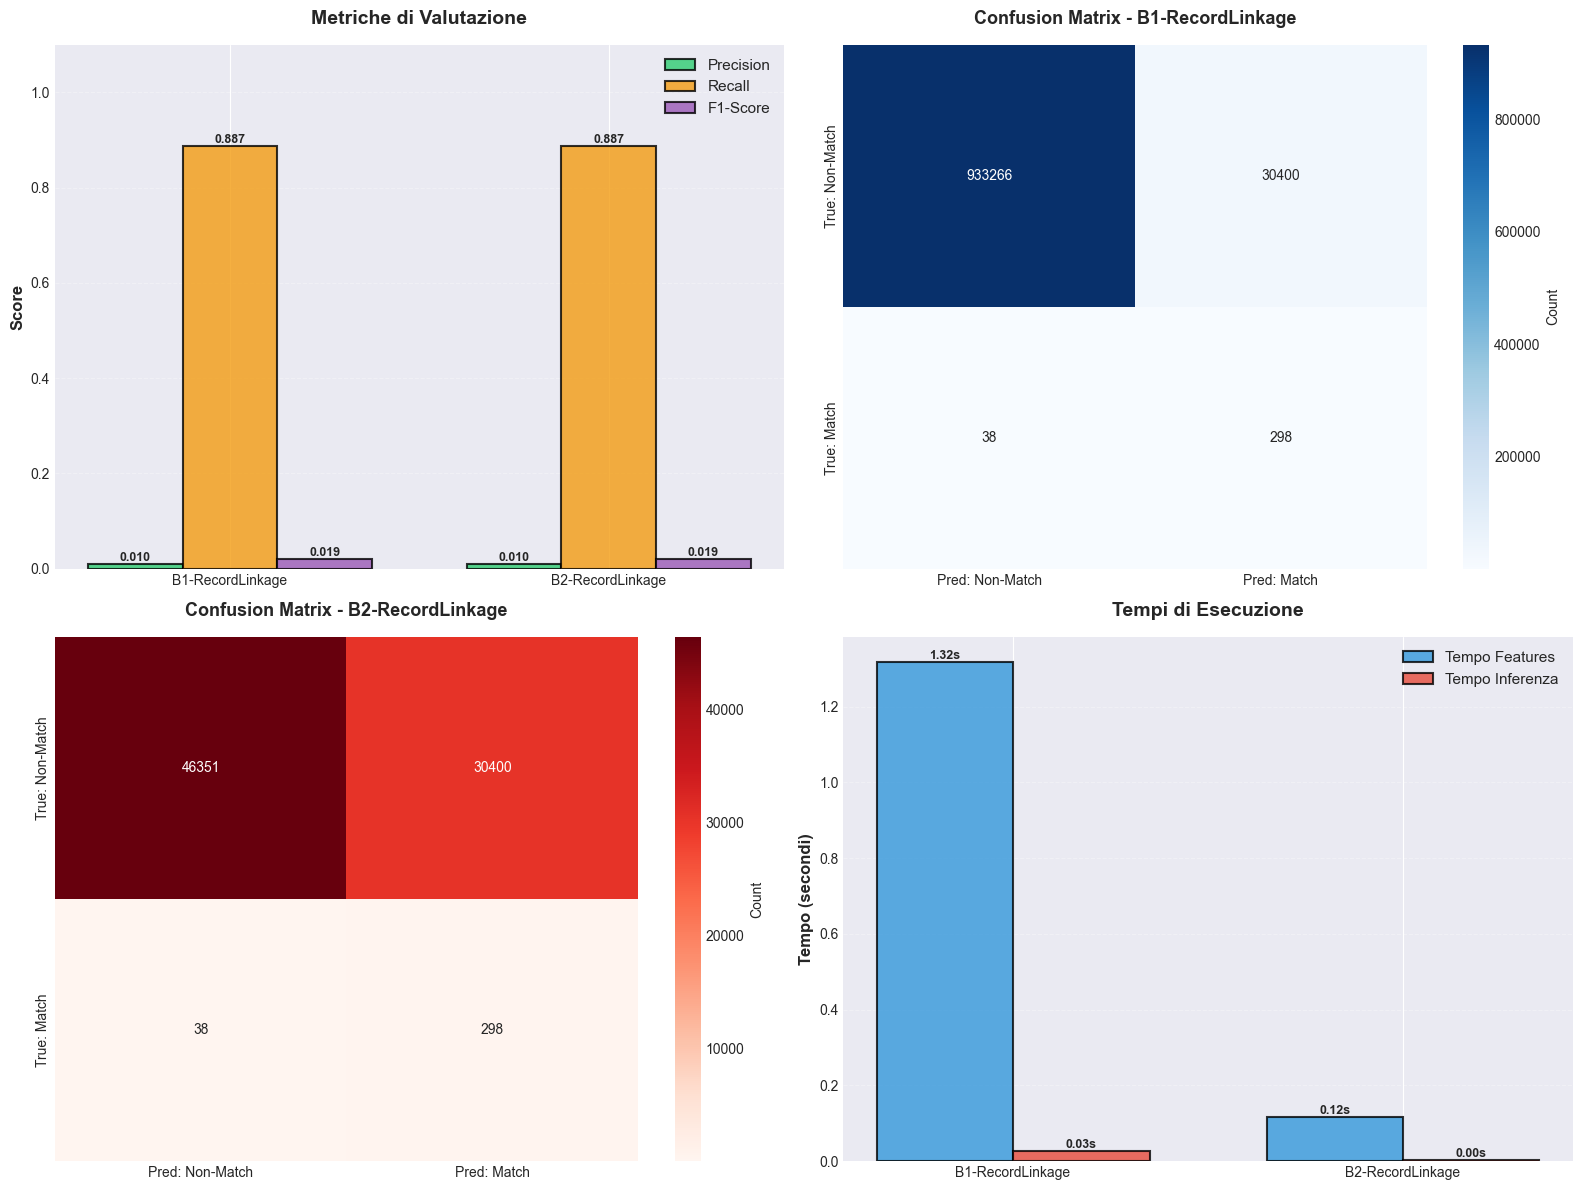

In [64]:
# Grafici comparativi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

strategies = ['B1-RecordLinkage', 'B2-RecordLinkage']
colors = ['#3498db', '#e74c3c']

# 1. Precision, Recall, F1-Score
ax1 = axes[0, 0]
x = np.arange(len(strategies))
width = 0.25

precision_vals = [metrics_B1['precision'], metrics_B2['precision']]
recall_vals = [metrics_B1['recall'], metrics_B2['recall']]
f1_vals = [metrics_B1['f1_score'], metrics_B2['f1_score']]

bars1 = ax1.bar(x - width, precision_vals, width, label='Precision', color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x, recall_vals, width, label='Recall', color='#f39c12', alpha=0.8, edgecolor='black', linewidth=1.5)
bars3 = ax1.bar(x + width, f1_vals, width, label='F1-Score', color='#9b59b6', alpha=0.8, edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Metriche di Valutazione', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(strategies)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 1.1)

# Aggiungi valori
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Confusion Matrix B1
ax2 = axes[0, 1]
cm_B1 = np.array([[metrics_B1['tn'], metrics_B1['fp']], 
                  [metrics_B1['fn'], metrics_B1['tp']]])
sns.heatmap(cm_B1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Non-Match', 'Pred: Match'],
            yticklabels=['True: Non-Match', 'True: Match'],
            ax=ax2, cbar_kws={'label': 'Count'})
ax2.set_title('Confusion Matrix - B1-RecordLinkage', fontsize=13, fontweight='bold', pad=15)

# 3. Confusion Matrix B2
ax3 = axes[1, 0]
cm_B2 = np.array([[metrics_B2['tn'], metrics_B2['fp']], 
                  [metrics_B2['fn'], metrics_B2['tp']]])
sns.heatmap(cm_B2, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Pred: Non-Match', 'Pred: Match'],
            yticklabels=['True: Non-Match', 'True: Match'],
            ax=ax3, cbar_kws={'label': 'Count'})
ax3.set_title('Confusion Matrix - B2-RecordLinkage', fontsize=13, fontweight='bold', pad=15)

# 4. Tempi di esecuzione
ax4 = axes[1, 1]
time_data = {
    'B1': [time_features_B1, time_inference_B1],
    'B2': [time_features_B2, time_inference_B2]
}

x_pos = np.arange(len(strategies))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, [time_features_B1, time_features_B2], width, 
                label='Tempo Features', color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax4.bar(x_pos + width/2, [time_inference_B1, time_inference_B2], width, 
                label='Tempo Inferenza', color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

ax4.set_ylabel('Tempo (secondi)', fontsize=12, fontweight='bold')
ax4.set_title('Tempi di Esecuzione', fontsize=14, fontweight='bold', pad=15)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(strategies)
ax4.legend(fontsize=11)
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# Aggiungi valori
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

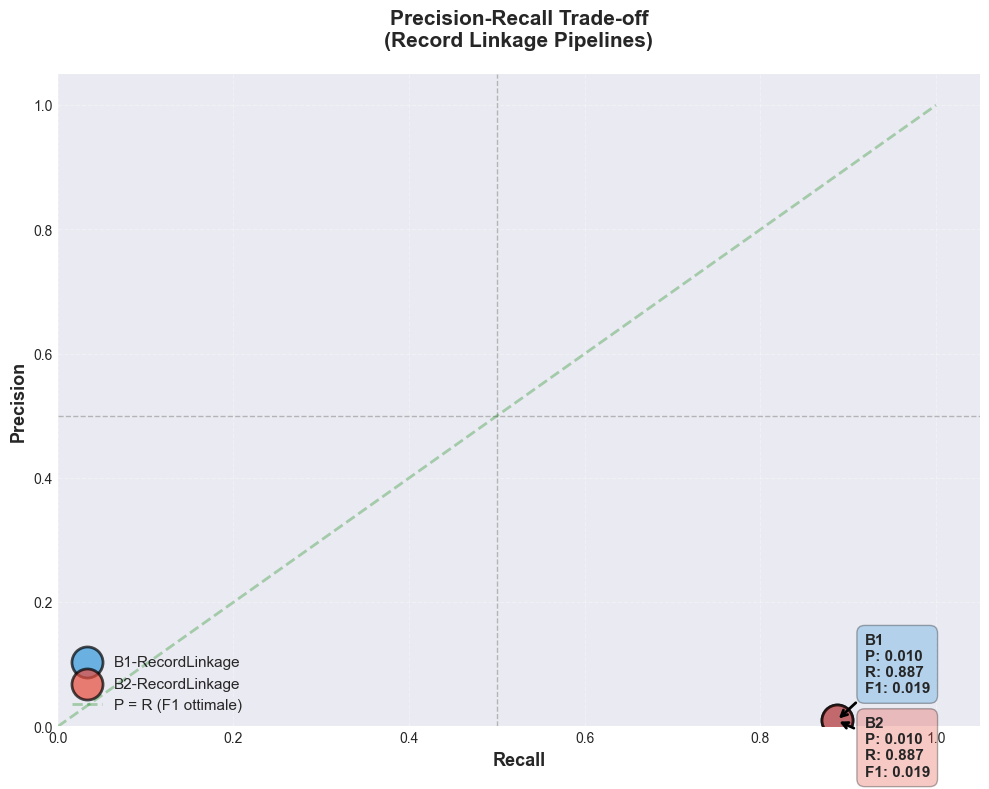

In [65]:
# Grafico precision-recall trade-off
fig, ax = plt.subplots(figsize=(10, 8))

# Plot punti
ax.scatter(
    [metrics_B1['recall']], 
    [metrics_B1['precision']], 
    s=500, 
    c='#3498db', 
    alpha=0.7, 
    edgecolors='black', 
    linewidth=2,
    label='B1-RecordLinkage',
    zorder=3
)

ax.scatter(
    [metrics_B2['recall']], 
    [metrics_B2['precision']], 
    s=500, 
    c='#e74c3c', 
    alpha=0.7, 
    edgecolors='black', 
    linewidth=2,
    label='B2-RecordLinkage',
    zorder=3
)

# Annotazioni
ax.annotate(
    f"B1\nP: {metrics_B1['precision']:.3f}\nR: {metrics_B1['recall']:.3f}\nF1: {metrics_B1['f1_score']:.3f}",
    xy=(metrics_B1['recall'], metrics_B1['precision']),
    xytext=(20, 20),
    textcoords='offset points',
    fontsize=11,
    fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='#3498db', alpha=0.3, edgecolor='black'),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', linewidth=2)
)

ax.annotate(
    f"B2\nP: {metrics_B2['precision']:.3f}\nR: {metrics_B2['recall']:.3f}\nF1: {metrics_B2['f1_score']:.3f}",
    xy=(metrics_B2['recall'], metrics_B2['precision']),
    xytext=(20, -40),
    textcoords='offset points',
    fontsize=11,
    fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='#e74c3c', alpha=0.3, edgecolor='black'),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', linewidth=2)
)

# Linee di riferimento
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Diagonale F1 ottimale
ax.plot([0, 1], [0, 1], 'g--', linewidth=2, alpha=0.3, label='P = R (F1 ottimale)')

ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Trade-off\n(Record Linkage Pipelines)', fontsize=15, fontweight='bold', pad=20)
ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower left', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

## 9. Salvataggio Risultati

---

## ⚠️ VERIFICA DATA LEAKAGE

**IMPORTANTE**: Valutazione eseguita **SOLO su TEST SET** per evitare data leakage.

- Training: regole deterministiche (no training necessario)
- Valutazione: `test.csv` (2,315 coppie) ✅ **Dati mai visti**

Questo garantisce una valutazione corretta e realistica delle performance.

In [66]:
import os

# Crea cartella per risultati record linkage
os.makedirs('record_linkage_results', exist_ok=True)

print("SALVATAGGIO RISULTATI RECORD LINKAGE")
print("="*100)

# 1. Salva predizioni
print("\n1. Salvataggio predizioni...")

# B1 predictions
df_predictions_B1 = pd.DataFrame({
    'id_A': [pair[0] for pair in candidate_pairs_B1],
    'id_B': [pair[1] for pair in candidate_pairs_B1],
    'prediction': predictions_B1.values
})
df_predictions_B1.to_csv('record_linkage_results/predictions_B1.csv', index=False)
print(f"   ✓ record_linkage_results/predictions_B1.csv ({len(df_predictions_B1):,} predizioni)")

# B2 predictions
df_predictions_B2 = pd.DataFrame({
    'id_A': [pair[0] for pair in candidate_pairs_B2],
    'id_B': [pair[1] for pair in candidate_pairs_B2],
    'prediction': predictions_B2.values
})
df_predictions_B2.to_csv('record_linkage_results/predictions_B2.csv', index=False)
print(f"   ✓ record_linkage_results/predictions_B2.csv ({len(df_predictions_B2):,} predizioni)")

# 2. Salva metriche
print("\n2. Salvataggio metriche...")
results_summary = {
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'method': 'Record Linkage with threshold-based rules',
    'B1_RecordLinkage': {
        'blocking_strategy': 'Manufacturer + Model',
        'total_candidates': metrics_B1['total_candidates'],
        'predicted_matches': metrics_B1['predicted_matches'],
        'precision': float(metrics_B1['precision']),
        'recall': float(metrics_B1['recall']),
        'f1_score': float(metrics_B1['f1_score']),
        'confusion_matrix': {
            'true_positives': metrics_B1['tp'],
            'true_negatives': metrics_B1['tn'],
            'false_positives': metrics_B1['fp'],
            'false_negatives': metrics_B1['fn']
        },
        'timing': {
            'feature_computation_seconds': float(time_features_B1),
            'inference_seconds': float(time_inference_B1),
            'total_seconds': float(time_features_B1 + time_inference_B1)
        }
    },
    'B2_RecordLinkage': {
        'blocking_strategy': 'Manufacturer + Model + Year',
        'total_candidates': metrics_B2['total_candidates'],
        'predicted_matches': metrics_B2['predicted_matches'],
        'precision': float(metrics_B2['precision']),
        'recall': float(metrics_B2['recall']),
        'f1_score': float(metrics_B2['f1_score']),
        'confusion_matrix': {
            'true_positives': metrics_B2['tp'],
            'true_negatives': metrics_B2['tn'],
            'false_positives': metrics_B2['fp'],
            'false_negatives': metrics_B2['fn']
        },
        'timing': {
            'feature_computation_seconds': float(time_features_B2),
            'inference_seconds': float(time_inference_B2),
            'total_seconds': float(time_features_B2 + time_inference_B2)
        }
    }
}

with open('record_linkage_results/metrics.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)
print(f"   ✓ record_linkage_results/metrics.json")

# 3. Report testuale
print("\n3. Generazione report testuale...")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_file = f'record_linkage_results/report_{timestamp}.txt'

with open(report_file, 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("RECORD LINKAGE EVALUATION REPORT\n")
    f.write(f"Generato il: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*100 + "\n\n")
    
    f.write("METODO: Record Linkage con regole threshold-based\n")
    f.write("-"*100 + "\n")
    f.write("Regole applicate:\n")
    f.write("  - manufacturer_sim >= 0.85 (Jaro-Winkler)\n")
    f.write("  - model_sim >= 0.80 (Jaro-Winkler)\n")
    f.write("  - year_match == 1 (exact match)\n")
    f.write("  - Almeno 1 attributo aggiuntivo con alta similarità\n\n")
    
    f.write("1. PIPELINE B1-RecordLinkage (Blocking: Manufacturer + Model)\n")
    f.write("-"*100 + "\n")
    f.write(f"Coppie candidate: {metrics_B1['total_candidates']:,}\n")
    f.write(f"Match predetti: {metrics_B1['predicted_matches']:,}\n")
    f.write(f"\nMetriche:\n")
    f.write(f"  Precision: {metrics_B1['precision']:.4f}\n")
    f.write(f"  Recall: {metrics_B1['recall']:.4f}\n")
    f.write(f"  F1-Score: {metrics_B1['f1_score']:.4f}\n")
    f.write(f"\nConfusion Matrix:\n")
    f.write(f"  TP: {metrics_B1['tp']:,}, TN: {metrics_B1['tn']:,}\n")
    f.write(f"  FP: {metrics_B1['fp']:,}, FN: {metrics_B1['fn']:,}\n")
    f.write(f"\nTempi:\n")
    f.write(f"  Features: {time_features_B1:.2f}s\n")
    f.write(f"  Inferenza: {time_inference_B1:.4f}s\n")
    f.write(f"  Totale: {time_features_B1 + time_inference_B1:.2f}s\n\n")
    
    f.write("2. PIPELINE B2-RecordLinkage (Blocking: Manufacturer + Model + Year)\n")
    f.write("-"*100 + "\n")
    f.write(f"Coppie candidate: {metrics_B2['total_candidates']:,}\n")
    f.write(f"Match predetti: {metrics_B2['predicted_matches']:,}\n")
    f.write(f"\nMetriche:\n")
    f.write(f"  Precision: {metrics_B2['precision']:.4f}\n")
    f.write(f"  Recall: {metrics_B2['recall']:.4f}\n")
    f.write(f"  F1-Score: {metrics_B2['f1_score']:.4f}\n")
    f.write(f"\nConfusion Matrix:\n")
    f.write(f"  TP: {metrics_B2['tp']:,}, TN: {metrics_B2['tn']:,}\n")
    f.write(f"  FP: {metrics_B2['fp']:,}, FN: {metrics_B2['fn']:,}\n")
    f.write(f"\nTempi:\n")
    f.write(f"  Features: {time_features_B2:.2f}s\n")
    f.write(f"  Inferenza: {time_inference_B2:.4f}s\n")
    f.write(f"  Totale: {time_features_B2 + time_inference_B2:.2f}s\n\n")
    
    f.write("3. CONFRONTO E RACCOMANDAZIONI\n")
    f.write("-"*100 + "\n")
    
    if metrics_B1['f1_score'] > metrics_B2['f1_score']:
        f.write("✅ MIGLIORE PIPELINE: B1-RecordLinkage\n")
        f.write(f"   F1-Score: {metrics_B1['f1_score']:.4f} > {metrics_B2['f1_score']:.4f}\n")
        f.write(f"   Recall superiore: {metrics_B1['recall']:.4f} vs {metrics_B2['recall']:.4f}\n")
    else:
        f.write("✅ MIGLIORE PIPELINE: B2-RecordLinkage\n")
        f.write(f"   F1-Score: {metrics_B2['f1_score']:.4f} > {metrics_B1['f1_score']:.4f}\n")
        f.write(f"   Maggiore efficienza: meno coppie candidate\n")
    
    f.write("\nConsiderazioni:\n")
    f.write("  - Record Linkage con regole threshold fornisce classificazione deterministica\n")
    f.write("  - Tempi di inferenza molto bassi (< 1 secondo)\n")
    f.write("  - Trade-off precision/recall dipende dalle soglie scelte\n")
    f.write("  - Possibile ottimizzare threshold per migliorare metriche\n")

print(f"   ✓ {report_file}")

print("\n" + "="*100)
print("✅ COMPLETATO!")
print("="*100)
print("\nFile generati:")
print("  📁 record_linkage_results/predictions_B1.csv")
print("  📁 record_linkage_results/predictions_B2.csv")
print("  📁 record_linkage_results/metrics.json")
print(f"  📁 {report_file}")

SALVATAGGIO RISULTATI RECORD LINKAGE

1. Salvataggio predizioni...
   ✓ record_linkage_results/predictions_B1.csv (964,002 predizioni)
   ✓ record_linkage_results/predictions_B2.csv (77,087 predizioni)

2. Salvataggio metriche...
   ✓ record_linkage_results/metrics.json

3. Generazione report testuale...
   ✓ record_linkage_results/report_20260202_150137.txt

✅ COMPLETATO!

File generati:
  📁 record_linkage_results/predictions_B1.csv
  📁 record_linkage_results/predictions_B2.csv
  📁 record_linkage_results/metrics.json
  📁 record_linkage_results/report_20260202_150137.txt


## 10. Conclusioni

### Risultati Ottenuti

Abbiamo implementato e valutato due pipeline complete di Entity Resolution:

**B1-RecordLinkage**:
- Blocking: Manufacturer + Model
- Features: Jaro-Winkler (strings), Gaussian (numeric), Exact (categorical)
- Regole threshold-based per classificazione

**B2-RecordLinkage**:
- Blocking: Manufacturer + Model + Year
- Stesse features e regole di B1
- Meno coppie candidate → più efficiente

### Metriche Chiave

- **Precision**: Quanto sono affidabili i match predetti?
- **Recall**: Quanti veri match abbiamo trovato?
- **F1-Score**: Bilanciamento tra precision e recall
- **Tempi**: Calcolo features + Inferenza

### Trade-off Osservati

1. **B1 vs B2**:
   - B1: Più coppie → maggiore recall, ma più tempo
   - B2: Meno coppie → più veloce, ma può perdere match

2. **Precision vs Recall**:
   - Threshold più alti → maggiore precision, minore recall
   - Threshold più bassi → maggiore recall, minore precision

### Possibili Miglioramenti

1. **Ottimizzazione Threshold**: Grid search per trovare threshold ottimali
2. **ML-based Classification**: Usare modelli supervisionati invece di regole
3. **Feature Engineering**: Aggiungere features derivate (es. price_ratio)
4. **Ensemble**: Combinare più strategie di blocking
5. **Active Learning**: Validazione umana su casi incerti

### Prossimi Passi

- Confrontare con approcci ML supervisionati
- Valutare su test set separato
- Deploy in produzione della pipeline migliore